# XGBoost Aplicado à Séries Temporais

<p> Autor: <a href="https://www.linkedin.com/in/vinicius-aquino-in/"  target="_blank" rel="noopener noreferrer">Vinicius Aquino</a></p>
<p>Data: 26/08/2024</p>

## Resumo

O presente texto é uma introdução aos modelos Gradient Boosting para séries temporais. Nele foram apresentados a classe de modelos de regressão não-paramétrica Gradient Boosting Decision Tree (GBDT) e o XGBoost, uma subclasse dos modelos GBDT. Por fim, foi aplicado o XGBoost no contexto de séries temporais. Apesar de ter sido escolhido o XGBoost, os problemas apresentados no texto, bem com as formas de resolução, podem ser usadas em qualquer Modelo de ML.

Pacotes usados:

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

plt.style.use('ggplot')

## Gradient Boosting Decision Tree:

Gradient Boosting Decision Tree (GBDT) é uma classe modelo dentro do ramo de regressões não-paramétricas. De forma muito resumnida, Regressões Não-Paramétricas são regressões mais flexíveis, onde o intuito é definir um modelo $r(X)$ que consiga predizer uma variável aleatória $Y$ a partir destas covariáveis. São flexíveis porque não fazem suposições acerca dos parâmetros a serem estimados, muito pelo contrário. Modelos de ML tipicamente são modelos não-paramétricos, como KNN, Redes Neurais e etc. 

Voltando a classe de modelos GBDT, como o nome sugere, eles são baseados em árvores de decisão. Diferente do Random Forest, os algoritmos GBDT não usam as árvores de decisão em paralelo. Explica-se. No Random Forest há várias árvores distintas vindas de reamostragens aleatórias de um conjunto de dados, onde a previsão é a média de todas as árvores juntas. No caso dos algoritmos GBDT é usado o processo de “Boosting”, onde se treina sequencialmente novas árvores de decisão que corrigem os erros das anteriores.

Isso é, a primeira árvore é treinada com os dados. A segunda com os resíduos que essa primeira árvore deixou. A terceira com os resíduos da segunda e assim sucessivamente. É um processo iterativo.

Um exemplo abaixo inspirado no livro Mãos à Obra: Aprendizado de Máquina com Scikit-Learn & TensorFlow:

Gerando dados aleatórios:

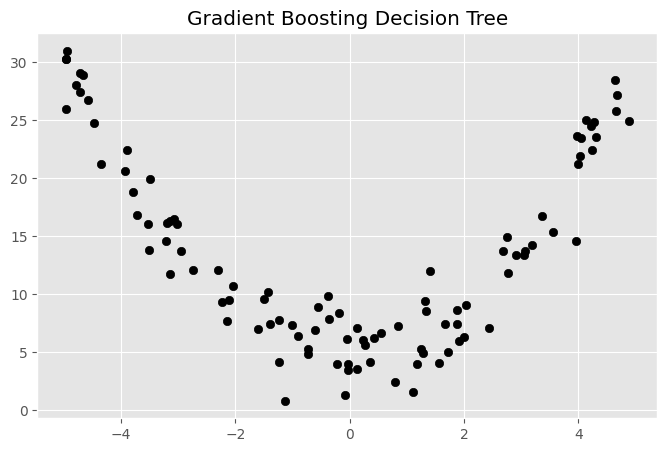

In [42]:
np.random.seed(633)
X = np.random.uniform(-5, 5, 100)
y = X ** 2 + 5 + np.random.normal(0, 2, 100)

f, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x=X, 
           y=y, 
           color='k')
plt.title("Gradient Boosting Decision Tree")           
plt.show()

Treinando um GBDT (árvores em sequência):

In [43]:
X = X.reshape(-1, 1)

tree_1 = DecisionTreeRegressor(max_depth=3).fit(X, y)
resid_1 = y - tree_1.predict(X=X) # Residuo da primeira Arvore
tree_2 = DecisionTreeRegressor(max_depth=3).fit(X, resid_1)

resid_2 = resid_1 - tree_2.predict(X=X) # Residuo da segunda Arvore
tree_3 = DecisionTreeRegressor(max_depth=3).fit(X, resid_2)

Dessa forma, cada árvore se especializou em aprender a “consertar” os erros das arvores que vieram antes. Voltando a ideia de regressão não-paramétrica, o modelo inicial dado é:


$$y_i = r_1(x_1) + \epsilon_{1i} = tree_1(x_i) + \epsilon_{1i}$$

A árvore 2 é treinada com os resíduos $\epsilon_{1}$ da árvore 1:

$$(y_i - tree_1(x_i)) = \epsilon_{1i} = r_2(x_1) + \epsilon_{2i} = tree_2(x_i) + \epsilon_{2i}$$


Por fim, a árvore 3 é treinada com os resíduos $\epsilon_{2}$ da árvore 2, isso é:

$$(y_i - tree_1(x_i)) - tree_2(x_i)= \epsilon_{2i} = r_3(x_1) + \epsilon_{3i} = tree_3(x_i) + \epsilon_{3i}$$

A idéia intuitiva é que se adicione novas árvores conforme isso reduza os erros em teste, até que não seja possível entender os padrões de $\epsilon_{q}$. Uma ideia similar a de Ruído Branco na metodologia de Box-Jenkis, mas sem supor que tenha distribuição identica, independente e normal.

Pode-se reescrever a equação acima como:


$$y_i - tree_1(x_i) - tree_2(x_i) - tree_3(x_i) = \epsilon_{3i} $$

$$ y_i = tree_1(x_i) + tree_2(x_i) + tree_3(x_i) + \epsilon_{3i}$$


Ou seja, a previsão da i-esima observação $y$ é a soma das previsões das árvores. Pensando na definição de regressão não-paramétrica, o modelo é dado por:

$$ y_i = r(x_i) + \epsilon_{i} = \sum_{j=1}^{q}tree_j(x_i) + \epsilon_{i}$$

Onde cada árvore $tree_j$ foi treinada sequencialmente.

Em python, o modelo treinado acima pode ser modelado como:

In [44]:
x_space = np.arange(-5, 6).reshape(-1, 1)
y_pred = sum(tree.predict(x_space) for tree in (tree_1, tree_2, tree_3))

Visualizando o modelo:

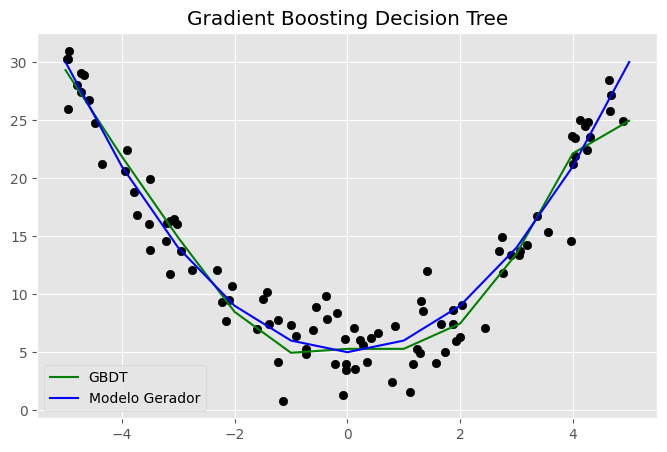

In [45]:
f, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x=X, 
           y=y, 
           color='k')
ax.plot(x_space, y_pred, label="GBDT", color="g")
plt.plot(x_space, x_space ** 2 + 5, label="Modelo Gerador", color="b")

plt.legend()
plt.title("Gradient Boosting Decision Tree") 
plt.show()

Um ponto de atenção desses modelos está na <b>extrapolação do espaço das covariáveis</b>. Como esses modelos, os não-paramétricos, ""perseguem"" os dados, geralmente possuem uma performance péssima quando usados para a extrapolação dos dados de treinamento. Além disso, por serem baseados em Árvores de Decisão, são construídos baseados em "quebras" do dataset (nós), o que acentua esse problema de extrapolação.


No exemplo abaixo, usamos o mesmo modelo, que foi treinado com dados entre 5 e -5 para prever valores além desse espaço:

In [46]:
x_space = np.arange(-7, 8).reshape(-1, 1)
y_pred = sum(tree.predict(x_space) for tree in (tree_1, tree_2, tree_3))

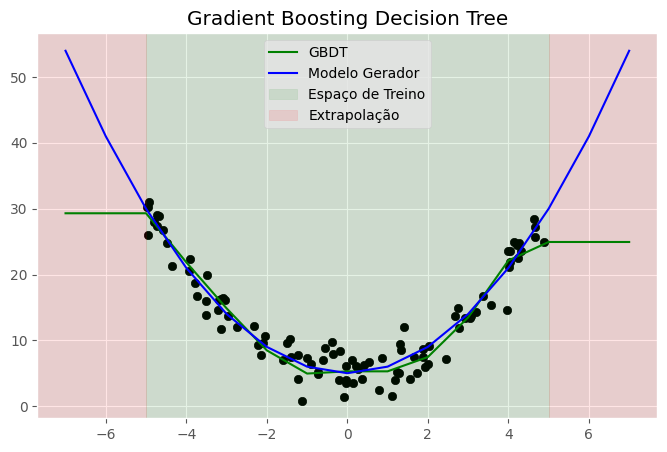

In [47]:
f, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x=X, 
           y=y, 
           color='k')
ax.plot(x_space, y_pred, label="GBDT", color="g")
plt.plot(x_space, x_space ** 2 + 5, label="Modelo Gerador", color="b")

x_lim, y_lim = plt.xlim(), plt.ylim()
plt.fill_betweenx(y_lim, -5, 5, color="g", alpha=.1, label="Espaço de Treino")
plt.fill_betweenx(y_lim, x_lim[0], -5, color="r", alpha=.1, label="Extrapolação")
plt.fill_betweenx(y_lim, 5, x_lim[1], color="r", alpha=.1)

plt.xlim(x_lim), plt.ylim(y_lim)

plt.legend()
plt.title("Gradient Boosting Decision Tree") 
plt.show()

Como pode ser visto, o modelo perde performance nessa extrapolação. Na verdade, a previsão do modelo se torna somente uma continuação da última previsão dentro do espaço de covariáveis. No caso, provavelmente o modelo definiu algo como "if x >= 4.5 then 25" e aplicou essa regra para a extrapolação.

Esse não é somente um problema dos modelos baseados em árvores: modelos de aprendizado de máquina só aprendem o que são ensinados e suas extrapolações são sempre limitadas. Sejam regressões lineares, sejam redes neurais. 

A partir de agora será usado o XGBoost sem tunagem de hiper-parâmetros, dado que a idéia é apenas entender sua aplicação em séries temporais.

## Modelando: XGBoost vs Regressão Linear para Previsão de Demanda 

### Baixando os dados: 

Os dados de demanda de Cerveja, Vinhos e Liquor no USA podem ser acessados <a href="https://raw.githubusercontent.com/flo7up/relataly_data/main/alcohol_sales/BeerWineLiquor.csv">aqui</a>.


In [48]:
path = "https://raw.githubusercontent.com/flo7up/relataly_data/main/alcohol_sales/BeerWineLiquor.csv"
df = pd.read_csv(path, 
                 parse_dates=["date"]).set_index("date")

df.tail()

,beer
date,
2018-08-01,4898
2018-09-01,4598
2018-10-01,4737
2018-11-01,5130
2018-12-01,6370


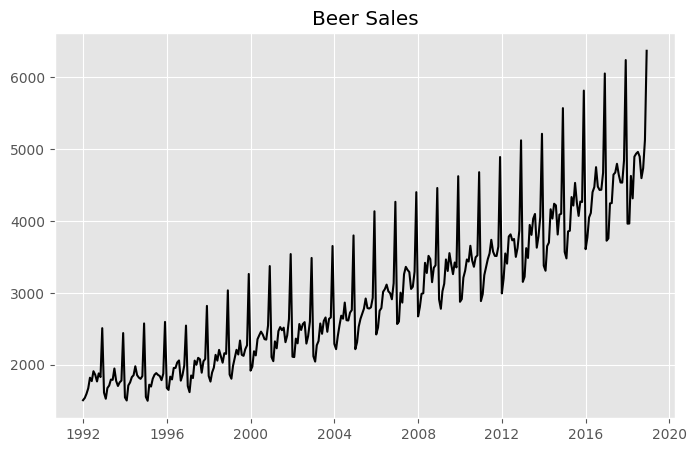

In [49]:
f, ax = plt.subplots(figsize=(8, 5))
plt.plot(df.beer, 'k')
plt.title("Beer Sales")
plt.show()

### Metodologia: {#sec-metodologia}

A idéia da análise é fazer um comparativo de desempenho conforme se aumenta a sofisticação do XGBoost. Serão feitas validações cruzadas onde o objetivo do modelo será prever a demanda do ano seguinte. Serão usados 72 meses para prever a demanda total dos próximos 12, como pode ser visto abaixo:


In [50]:
tscv = TimeSeriesSplit(n_splits=20,
                       max_train_size=72,
                       test_size=12
                       )
tscv_generator = tscv.split(df)

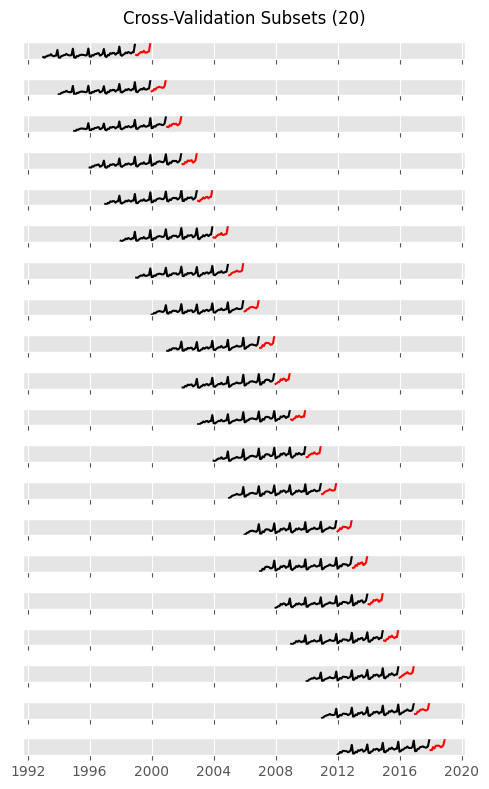

In [51]:
n = len(list(tscv.split(df)))

f, axs = plt.subplots(nrows=n,
                      ncols=1,
                      sharex=True,
                      figsize=(5, 8))

f.suptitle(f"Cross-Validation Subsets ({n})")

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    axs[i].plot(df.iloc[train_index], 'k')
    axs[i].plot(df.iloc[test_index], 'r')
    axs[i].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

### Modelando Tendência

É bem nítido que há uma tendência na série. Isso é, intrisicamente no Processo Estocástico (PE) gerador da série há alguma função do tempo que, sistematicamente, soma algum incremento na série, multiplique ela por um fator > 1 ou faça ambos ao mesmo tempo.

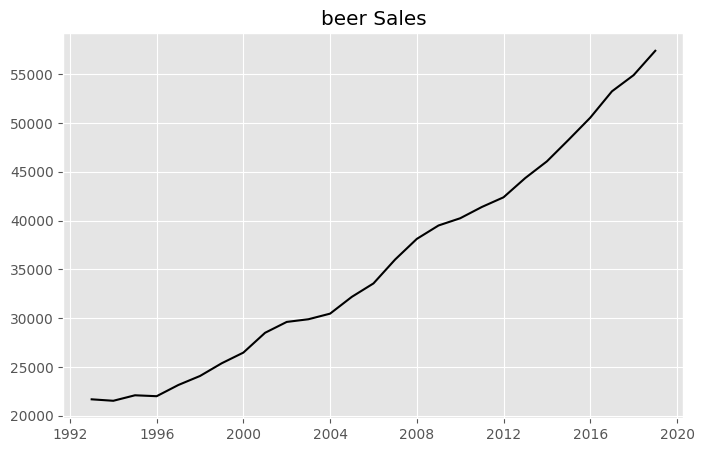

In [52]:
f, ax = plt.subplots(figsize=(8, 5))
plt.plot(df.beer.resample('1YE').sum(), 'k')
plt.title("beer Sales")
plt.show()

Por uma questão de simplicidade de modelo, será usado uma relação linear para descrever essa suposta função. O modelo da demanda no caso da regressão linear será:

$$y_t = \beta_0 + \beta_{trend}t$$

A interpretação dos parâmetros $\beta_0$ e $\beta_{trend}$ é bem intuitiva. Como o input é o ano do modelo, $\beta_{trend}$ é a variação média anual e o $\beta_{0}$ a “demanda inicial” no ano 0 (sim, não faz sentido e é bem comum). No caso, não tem como saber exatamente como será o modelo do XGBoost e a vantagem dessa classe de modelos é exatamente essa. Por se tratar de uma regressão não-paramétrica, ele encontrará, nos dados, a melhor forma de descrever essa tendência em função do tempo.

Criando uma função para automatizar o processo de data featuring para a tendência:

In [53]:
def data_featuring_trend(df):
    X = df.copy()
    X.loc[:, 'ano'] = [i.year for i in X.index]

    return X.drop(labels=['beer'],
                   axis=1)

Criando o modelo para os 20 backtest:

In [54]:
cv_generator = tscv.split(df)

acc_reg_1 = []
acc_xgb_1 = []
for i, (train_index, test_index) in enumerate(tscv.split(df.beer.values)):
    

    # Separando teste do treino
    y_train = df.iloc[train_index].copy()
    X_train = data_featuring_trend(y_train)

    y_test = df.iloc[test_index].copy()
    X_test = data_featuring_trend(y_test)

    # Treinando modelos
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X_train.values, y_train)
    y_reg_pred = reg.predict(X=X_test.values)

    xgb = XGBRegressor()
    xgb.fit(X_train.values, y_train.values.ravel())
    y_xgb_pred = xgb.predict(X=X_test.values)


    # Salvando acurácia dos modelos
    acc_reg_1.append(1-abs(y_test.beer.values.sum()- y_reg_pred.sum())/y_test.beer.values.sum())
    acc_xgb_1.append(1-abs(y_test.beer.values.sum()- y_xgb_pred.sum())/y_test.beer.values.sum())


acc_reg_1,acc_xgb_1 = np.array(acc_reg_1), np.array(acc_xgb_1)
print(acc_reg_1)
print()
print(acc_xgb_1)
print()
print(f"XGBoost vence: {(acc_xgb_1>acc_reg_1).sum()} ({round(100*(acc_xgb_1>acc_reg_1).mean(), 2)} %)")
print()
print(f"regressão vence: {(acc_xgb_1<acc_reg_1).sum()} ({round(100*(acc_xgb_1<acc_reg_1).mean(), 2)} %)")

[0.96975878 0.95273909 0.9895277  0.96724426 0.95933134 0.996359
 0.98306074 0.94584999 0.95548503 0.9947364  0.96824616 0.97035176
 0.97464616 0.98857959 0.97895506 0.97236466 0.97753643 0.97691234
 0.9985189  0.99684608]

[0.95867934 0.92875407 0.96239128 0.99086754 0.98112817 0.94656535
 0.95894754 0.93200233 0.94460743 0.96516789 0.98158768 0.97207787
 0.97662276 0.95552783 0.96286553 0.95423104 0.95521251 0.94920657
 0.96978884 0.95652298]

XGBoost vence: 5 (25.0 %)

regressão vence: 15 (75.0 %)


Como pode ser visto, o XGBoost perfoma acima da regressão linear em somente 5 de 20 casos (25%).

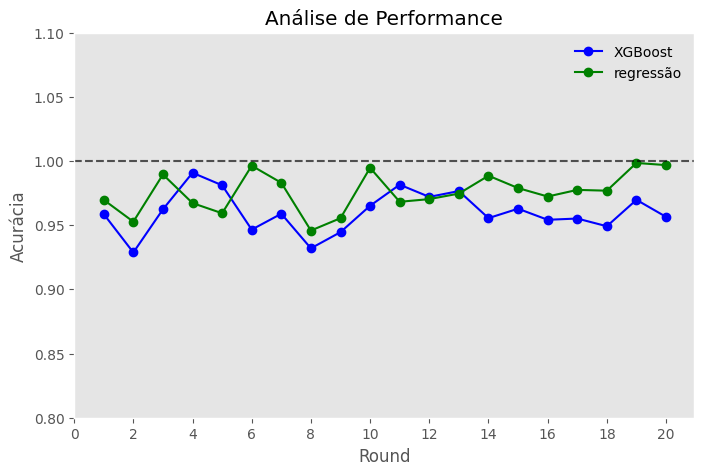

In [55]:
f, ax = plt.subplots(figsize=(8, 5))

x = np.arange(1, len(acc_xgb_1) + 1)
ax.plot(x, acc_xgb_1, 'bo-', label='XGBoost')
ax.plot(x, acc_reg_1, 'go-', label='regressão')
ax.axhline(y=1, color='k', ls='--', alpha=.3)

ax.set_xlabel("Rodada")
ax.set_ylabel("Acurácia")
plt.ylim(.8, 1.1)
plt.axhline(y=1, color='k', alpha=.5, ls='--')
plt.legend(frameon=False)

plt.xticks(np.arange(0, 22, 2))
plt.xlabel("Round")
plt.ylabel("Acurácia")
plt.title("Análise de Performance")
plt.grid(False)
plt.show()

Mas afinal, o que a regressão linear entendeu que o XGBoost não entendeu? O que pode explicar esse melhor desempenho do modelo mais simples?

Para responder essa questão, o próximo passo é explorar pelo menos o último modelo treinado e entender o que aconteceu.

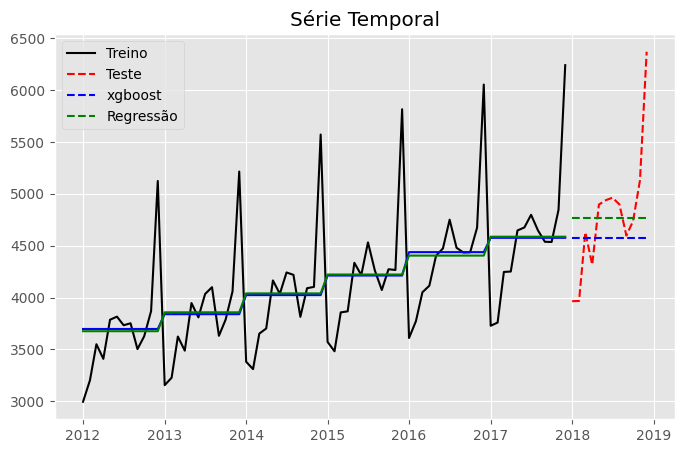

In [56]:
f, ax = plt.subplots(figsize=(8, 5))
plt.plot(y_train, 'k', label='Treino')
plt.plot(y_test, 'r--', label='Teste')
plt.plot(y_test.index, y_xgb_pred, 'b--', label='xgboost')
plt.plot(y_train.index, xgb.predict(X=X_train.values), 'b')

plt.plot(y_test.index, y_reg_pred, 'g--', label='Regressão')
plt.plot(y_train.index, reg.predict(X=X_train.values), 'g')

plt.legend()
plt.title("Série Temporal")
plt.show()

Fazendo um gráfico de dispersão das observações da série em termos das variáveis de entrada (ano):

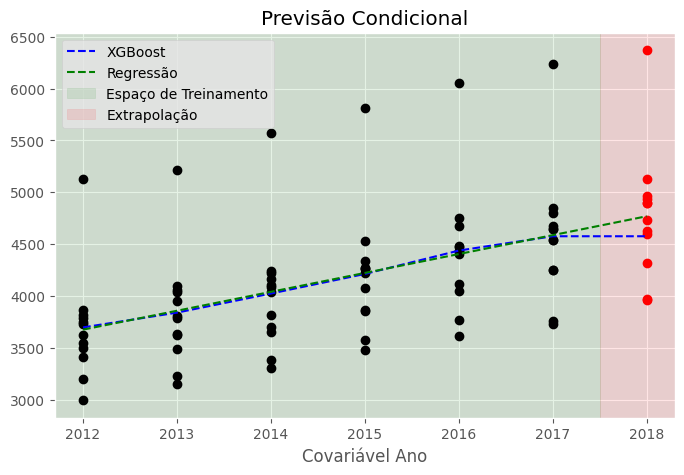

In [57]:
f, ax = plt.subplots(figsize=(8, 5))
plt.plot(y_train.index.year, y_train, 'ko')
plt.plot(y_test.index.year, y_test, 'ro')

plt.plot(y_train.index.year.to_list()+[y_test.index[0].year], list(xgb.predict(X=X_train.values)) + [y_xgb_pred[0]], 'b--', label="XGBoost")
plt.plot(y_train.index.year.to_list() + [y_test.index.year[0]], list(reg.predict(X=X_train.values)) + [y_reg_pred[0]], 'g--', label="Regressão")

ylim, xlim = plt.ylim(), plt.xlim()
plt.fill_betweenx(ylim, xlim[0], 2017.5, alpha=.1, label="Espaço de Treinamento", color="g")
plt.fill_betweenx(ylim, 2017.5, xlim[-1], alpha=.1, label="Extrapolação", color="r")
plt.ylim(ylim), plt.xlim(xlim)

plt.title("Previsão Condicional")
plt.xlabel("Covariável Ano")

plt.legend()
plt.show()

O primeiro ponto é quanto a previsão “linear”. Sim, naturalmente a previsão vai ser uma reta horizontal. Dado que em todos os 12 pontos do ano há o mesmo input (o ano corrente). Ao longo do texto essa previsão se tornará mais sofisticada.

O segundo ponto é a fraquíssima capacidade do XGBoost em extrapolar a previsão para fora do espaço de treino das covariáveis. Bom, isso não é exatamente um problema exclusivo do XGBoost. E isso também já foi abordado no começo do texto.

A regressão linear também sofre com isso. Inclusive, quando se aprende regressão linear, aprende-se que deve-se evitar essa extrapolação. E, nesse caso, performou melhor por ser mais simples. É um modelo que apenas estima a varição ano a ano média, o que foi o suficiente pra performar acima do XGBoost (que basicamente supôs um crescimento zero).

Analisando as nuances do teste, o que foi feito, em termos práticos, foi ensinar um modelo o padrão da demanda entre os inputs de 2012 a 2017. No entanto, o que foi exigido foi prever como vai ser essa demanda em 2018. Parece até sacanagem com o coitado. De fato, ele entendeu a demanda nos dados de treino, mas a falta de observações do futuro não permitiu ele entender o seu comportamento.


Por hora, fica no radar essa eventual limitação no que tange ao intervalo de predição.


### Modelando a Sazonalidade:

A série tem um claro fator sazonal que pode ser observado na vizualização abaixo:

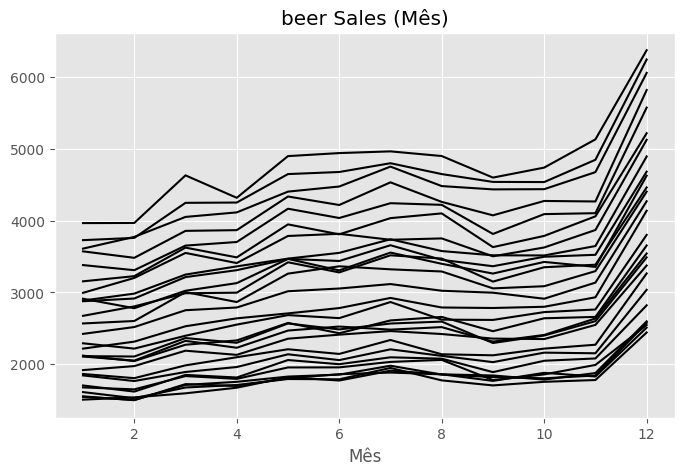

In [58]:
f, ax = plt.subplots(figsize=(8, 5))

for year in df.index.year.unique():
    df_temp = df.loc[df.index.year == year]
    ax.plot(df_temp.index.month, df_temp.beer, color='k')

plt.xlabel("Mês")
plt.title("beer Sales (Mês)")
plt.show()

E, agora, que já há uma previsão da tendência, o próximo passo é saber o quanto a demanda vai variar em cada mês em relação ao “nível” médio anual. Dessa forma, o modelo de regressão linear ganha essa cara:

$$y_{t} = \beta_{0} + \beta_{trend}t + \beta_{jan}x_{jan} + \beta_{fev}x_{fev}+ ... + \beta_{nov}x_{nov}$$

Onde as variáveis $x_{k}'s$ são variáveis binárias que correspondem ao mês. Isso é, $x_{jan}$ vale 1 se o mês for janeiro, 0 caso contrário. E, portanto, $\beta_{jan}$ é o “prêmio” que se soma a demanda por ser janeiro, podendo ser positivo ou não. O input da regressão linear DEVE ser feito via variáveis dummies, dado que o mês é uma variável qualitativa nominal e o modelo é linear. Não há dezembro nas variáveis dummies por uma questão de multicolinearidade (o intercepto seria uma relação linear perfeita de todas as variáveis de sazonalidade).

Novamente, não é possível saber como o XGBoost vai ser interpretado, dado que trata-se de uma regressão não-paramétrica. O input da sazonalidade PODE ser dado como se o mês fosse uma variável numérica, dado que o modelo é baseado em árvores de decisão e conseguiria “captar” o movimento da sazonalidade. No entanto, será usado, também, variáveis dummies.

Criando funções que adicionam variáveis de sazonalidade:

In [59]:
def data_featuring_sazo(df):
    X = df.copy()
    X.loc[:, 'year'] = [i.year for i in X.index]
    X.loc[:, 'month'] = [i.month for i in X.index]
    
    X_sazo = pd.get_dummies(X['month']).astype("category")
    X = pd.concat([X, X_sazo], axis=1)

    return X.drop(labels=['month', 'beer', 12],
                    axis=1).astype('int')

Vizualizando quais seriam os inputs:


In [60]:
data_featuring_sazo(df.iloc[-12:])\
                   .reset_index(drop=True)

,year,1,2,3,4,5,6,7,8,9,10,11
0,2018,1,0,0,0,0,0,0,0,0,0,0
1,2018,0,1,0,0,0,0,0,0,0,0,0
2,2018,0,0,1,0,0,0,0,0,0,0,0
3,2018,0,0,0,1,0,0,0,0,0,0,0
4,2018,0,0,0,0,1,0,0,0,0,0,0
5,2018,0,0,0,0,0,1,0,0,0,0,0
6,2018,0,0,0,0,0,0,1,0,0,0,0
7,2018,0,0,0,0,0,0,0,1,0,0,0
8,2018,0,0,0,0,0,0,0,0,1,0,0
9,2018,0,0,0,0,0,0,0,0,0,1,0


Criando o modelo para os 20 backtests: 

In [61]:
cv_generator = tscv.split(df)

acc_reg_2 = []
acc_xgb_2 = []
for i, (train_index, test_index) in enumerate(tscv.split(df.beer.values)):
    # Separando teste do treino
    y_train = df.iloc[train_index].copy()
    X_train = data_featuring_sazo(y_train)

    y_test = df.iloc[test_index].copy()
    X_test = data_featuring_sazo(y_test)

    # Treinando modelos
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X_train.values, y_train)
    y_reg_pred = reg.predict(X=X_test.values)

    xgb = XGBRegressor()
    xgb.fit(X_train.values, y_train.values.ravel())
    y_xgb_pred = xgb.predict(X_test.values)

    # Salvando acurácia dos modelos
    acc_reg_2.append(1-abs(y_test.beer.values.sum()- y_reg_pred.sum())/y_test.beer.values.sum())
    acc_xgb_2.append(1-abs(y_test.beer.values.sum()- y_xgb_pred.sum())/y_test.beer.values.sum())


acc_reg_2,acc_xgb = np.array(acc_reg_2), np.array(acc_xgb_2)
print(acc_reg_2)
print()
print(acc_xgb)
print()
print(f"XGBoost vence: {(acc_xgb>acc_reg_2).sum()} ({round(100*(acc_xgb>acc_reg_2).mean(), 2)} %)")
print()
print(f"regressão vence: {(acc_xgb<acc_reg_2).sum()} ({round(100*(acc_xgb<acc_reg_2).mean(), 2)} %)")

[0.96975878 0.95273909 0.9895277  0.96724426 0.95933134 0.996359
 0.98306074 0.94584999 0.95548503 0.9947364  0.96824616 0.97035176
 0.97464616 0.98857959 0.97895506 0.97236466 0.97753643 0.97691234
 0.9985189  0.99684608]

[0.95846651 0.92909444 0.96159648 0.99043659 0.98197803 0.94585835
 0.95772977 0.93218758 0.94337105 0.96446503 0.98153546 0.97121937
 0.9757154  0.95458422 0.96269496 0.95324182 0.95416837 0.9484232
 0.96875804 0.9556873 ]

XGBoost vence: 5 (25.0 %)

regressão vence: 15 (75.0 %)


E o XGBoost segue performando ABAIXO da regressão linear. Dando uma explorada na forma com que ele lidou com os dados:

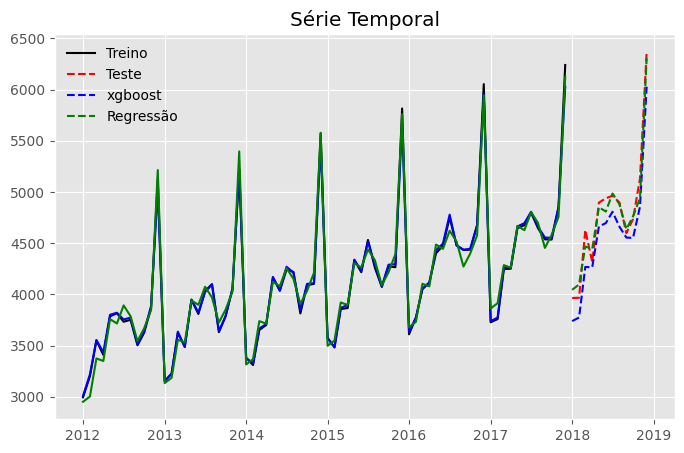

In [62]:
f, ax = plt.subplots(figsize=(8, 5))
plt.plot(y_train, 'k', label='Treino')
plt.plot(y_test, 'r--', label='Teste')
plt.plot(y_test.index, y_xgb_pred, 'b--', label='xgboost')

plt.plot(y_train.index, xgb.predict(X=X_train.values), 'b')
plt.plot(y_test.index, y_reg_pred, 'g--', label='Regressão')
plt.plot(y_train.index, reg.predict(X=X_train.values), 'g')

plt.legend(frameon=False)
plt.title("Série Temporal")
plt.show()

O XGBoost parece entender o padrão nos dados de treino, mas performa mal nos dados de teste. O mais natural seria imaginar um cenário de overfitting e optar pela "simplificação" do modelo, mas nesse caso o buraco é mais embaixo. A falta de performance está relacionada com a incapacidade de prever a variável $y_t$ quando a covariável ano tem valor igual a 2018 (novamente, a questão da extrapolação). Sim, é overfitting. O modelo "repetiu" os dados de treinamento, todavia, isso está mais relacionado a covariáveis do que necessariamente complexidade do modelo.

Plotando a previsão sob as covariáveis:

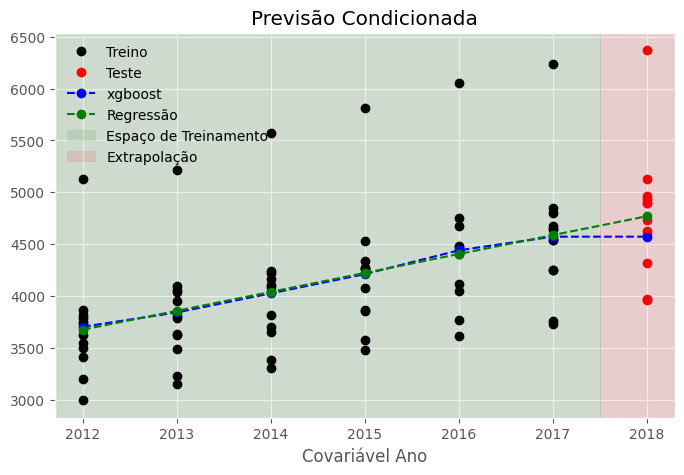

In [63]:
f, ax = plt.subplots(figsize=(8, 5))

plt.plot(y_train.index.year, y_train, 'ko', label='Treino')
plt.plot(y_test.index.year, y_test, 'ro', label='Teste')

xgb_model = list(xgb.predict(X=X_train.values)) + list(y_xgb_pred)
xgb_model = pd.Series(xgb_model,
                      index=X_train.index.year.to_list()+X_test.index.year.to_list())
plt.plot(xgb_model.groupby(level=0).mean(), 'b--o', label='xgboost')

reg_model = list(reg.predict(X=X_train.values)) + list(y_reg_pred)
reg_model = pd.Series(reg_model,
                      index=X_train.index.year.to_list()+X_test.index.year.to_list())
plt.plot(reg_model.groupby(level=0).mean(), 'g--o', label='Regressão')



ylim, xlim = plt.ylim(), plt.xlim()
plt.fill_betweenx(ylim, xlim[0], 2017.5, alpha=.1, label="Espaço de Treinamento", color="g")
plt.fill_betweenx(ylim, 2017.5, xlim[-1], alpha=.1, label="Extrapolação", color="r")
plt.ylim(ylim), plt.xlim(xlim)


plt.xlabel("Covariável Ano")
plt.legend(frameon=False)
plt.title("Previsão Condicionada")
plt.show()

Como pode ser visto, a previsão média do modelo XGBoost para a covariável 2018 foi idêntica a sua previsão para covariável 2017, a mais próxima dentro do espaço de treinamento. Novamente, overfitting, mas não qualquer overfitting. A simplificação do modelo NÃO vai gerar ganho de performance nesse caso.

Analisando a covariável mês:

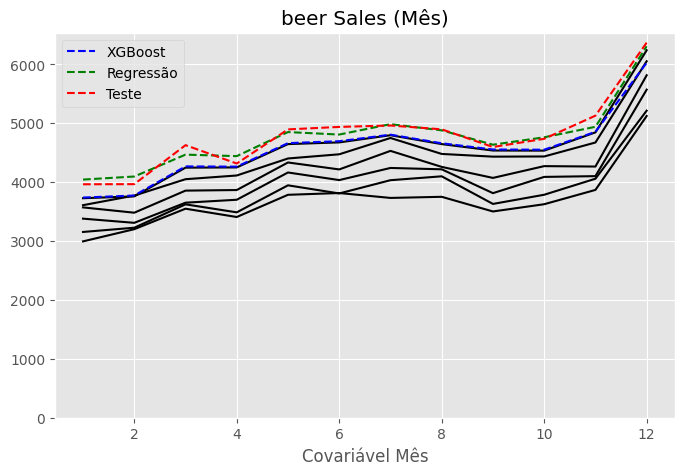

In [64]:
f, ax = plt.subplots(figsize=(8, 5))
for year in y_train.index.year.unique():
    df_temp = y_train.loc[y_train.index.year == year]
    ax.plot(df_temp.index.month, df_temp.beer, color='k')

ax.plot(y_test.index.month, y_xgb_pred, 'b--', label='XGBoost')
ax.plot(y_test.index.month, y_reg_pred, 'g--', label='Regressão')
ax.plot(y_test.index.month, y_test, 'r--', label='Teste')

plt.ylim(0)
plt.legend()
plt.xlabel("Covariável Mês")
plt.title("beer Sales (Mês)")
plt.show()


Nesse caso, a previsão sob as covariáveis do mês parece estar exatamente sobre o ano anterior. A sobreposição com o provável ano 2017 indica que a tendência dos dados forçou o modelo apenas a repetir a previsão passada por estar "navegando" no escuro (extrapolando as covariáveis). 

Se abríssemos a caixa do modelo, provavelmente teríamos as primeiras árvores como:

"if ano >= 2017 and março=1 then 4268.36"

In [65]:
# Gerando amostras para evidênciar ponto
df_test = pd.DataFrame(index=pd.date_range("2017-03-01", "2025-12-01", freq="1ME"),
                       columns=["beer"])

# Gerando features
df_test = data_featuring_sazo(df_test)

# Pegando só março
df_test = df_test.loc[df_test[3]==1]

df_test.head()

,year,1,2,3,4,5,6,7,8,9,10,11
2017-03-31,2017,0,0,1,0,0,0,0,0,0,0,0
2018-03-31,2018,0,0,1,0,0,0,0,0,0,0,0
2019-03-31,2019,0,0,1,0,0,0,0,0,0,0,0
2020-03-31,2020,0,0,1,0,0,0,0,0,0,0,0
2021-03-31,2021,0,0,1,0,0,0,0,0,0,0,0


In [66]:
print(xgb.predict(df_test.values))

[4268.36 4268.36 4268.36 4268.36 4268.36 4268.36 4268.36 4268.36 4268.36]


In [67]:
y_train.loc["2017-03-01"]

beer    4247
Name: 2017-03-01 00:00:00, dtype: int64

Nesse caso, o dado de treino de março de 2017 era $4247$. A previsão para esse mês no modelo foi $4268$. Nada mal, um erro de $0.49\%$. O ponto é que o modelo aplicou essa regra para todos os anos seguintes, o que gerou praticamente um naive-forecast. Isso porque, novamente, por ser um modelo constrúido baseado em árvores, em algum momento definiu a dita regra:

"if ano >= 2017 and março=1 then 4268.36"

Que, sim, é válida para 2017, mas inútil para os anos seguintes.

## Removendo Tendência:

Será feito uma transformação na variável $y_t$ a fim de que a previsão dela seja “facilitada” para os modelos.

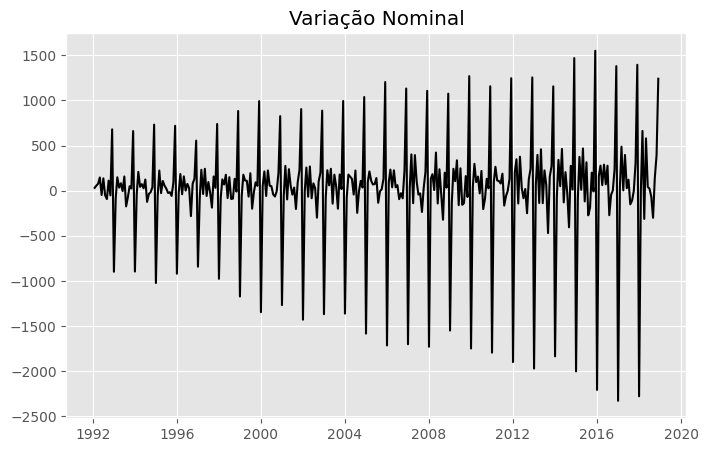

In [68]:
f, ax = plt.subplots(figsize=(8, 5))

ax.plot(df.diff().dropna()['beer'], 'k')
plt.title("Variação Nominal")
plt.show()

A série continua, ainda, não estacionária, posto que sua variância aumenta em função do tempo. A gente pode remover essa heterocedasticidade usando o logaritmo da série (e o derivando, dado que ele também não é estacionário):

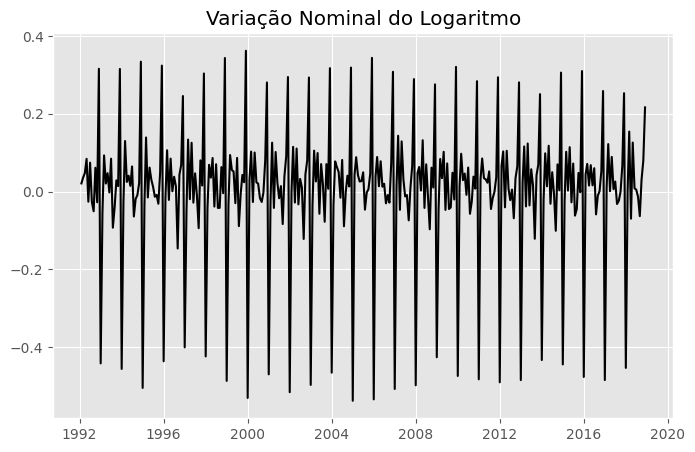

In [69]:
f, ax = plt.subplots(figsize=(8, 5))

ax.plot((np.log(df['beer'])).diff().dropna(), 'k')
plt.title("Variação Nominal do Logaritmo")
plt.show()

Neste caso, a série passa a se comportar de forma estacionária. Rodando os modelos novamente e removendo a covariável ano (que nesse caso não trará mais nenhuma informação, posto que não há mais tendência):

In [70]:
acc_reg_3 = []
acc_xgb_3 = []
for i, (train_index, test_index) in enumerate(tscv.split(df.beer.values)):

    # Separando teste do treino
    y_train = df.iloc[train_index].copy()
    y_test = df.iloc[test_index].copy()

    # Fazendo a transformação
    df_temp = np.log(pd.concat([y_train, y_test])).diff().dropna()
    y_train, y_test = df_temp.loc[y_train.index[1:]], df_temp.loc[y_test.index]


    X_train = data_featuring_sazo(y_train).drop(labels=["year"], axis=1)
    X_test = data_featuring_sazo(y_test).drop(labels=["year"], axis=1)
    
    # Treinando modelos
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X_train.values, y_train)
    y_reg_pred = reg.predict(X=X_test.values)

    xgb = XGBRegressor()
    xgb.fit(X_train.values, y_train)
    y_xgb_pred = xgb.predict(X=X_test.values)


    # Retornando as variáveis para escala padrão (integrando):
    y_test = np.array([0] + list(y_train.beer.values) + list(y_test.beer.values))
    y_test = np.exp(np.log(df.iloc[train_index[0], 0]) + y_test.cumsum())[-12:]


    y_reg_pred = np.array([0] + list(reg.predict(X=X_train.values)[:,0]) + list(y_reg_pred[:,0]))
    y_reg_pred = np.exp(np.log(df.iloc[train_index[0], 0]) + y_reg_pred.cumsum())

    y_xgb_pred = np.array([0] + list(xgb.predict(X=X_train.values)) + list(y_xgb_pred))
    y_xgb_pred = np.exp(np.log(df.iloc[train_index[0], 0]) + y_xgb_pred.cumsum())


    # Salvando acurácia dos modelos
    acc_reg_3.append(1-abs(y_test.sum() - y_reg_pred[-12:].sum())/y_test.sum())
    acc_xgb_3.append(1-abs(y_test.sum()- y_xgb_pred[-12:].sum())/y_test.sum())


acc_reg_3,acc_xgb_3 = np.array(acc_reg_3), np.array(acc_xgb_3)
print(acc_reg_3)
print()
print(acc_xgb_3)
print()
print(f"XGBoost vence: {(acc_xgb_3>acc_reg_3).sum()} ({round(100*(acc_xgb_3>acc_reg_3).sum()/n, 2)} %)")
print()
print(f"regressão vence: {(acc_xgb_3<acc_reg_3).sum()} ({round(100*(acc_xgb_3<acc_reg_3).sum()/n, 2)} %)")

[0.97791268 0.97532984 0.97926429 0.94699662 0.99840119 0.97844555
 0.98353859 0.99307375 0.96906145 0.97516495 0.97668471 0.98575403
 0.99092345 0.99486025 0.99371951 0.97727946 0.99044558 0.99114195
 0.99404961 0.99367974]

[0.96222437 0.95883562 0.96374524 0.93170607 0.98668968 0.99358349
 0.99841658 0.97806518 0.98381625 0.99018077 0.99136643 0.99930242
 0.99403646 0.99053868 0.97984574 0.99048867 0.99583566 0.99536321
 0.98065699 0.99360972]

XGBoost vence: 10 (50.0 %)

regressão vence: 10 (50.0 %)


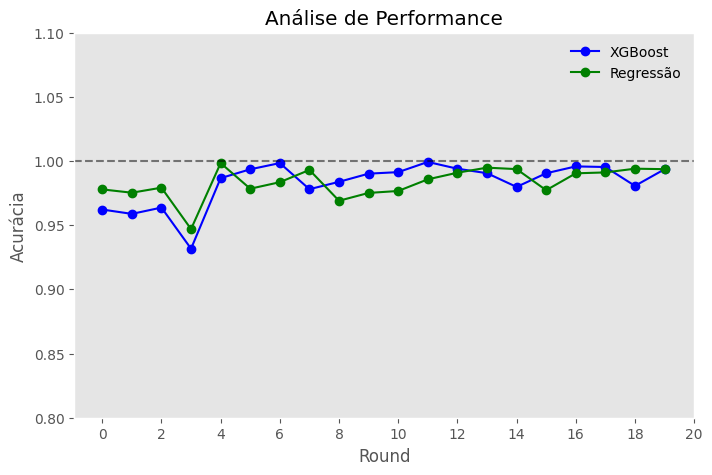

In [71]:
f, ax = plt.subplots(figsize=(8, 5))

ax.plot(acc_xgb_3, 'b-o', label='XGBoost')
ax.plot(acc_reg_3, 'g-o', label='Regressão')
plt.ylim(.8, 1.1)
plt.axhline(y=1, color='k', alpha=.5, ls='--')
plt.legend(frameon=False)

plt.xticks(np.arange(0,22,2))
plt.xlabel("Round")
plt.ylabel("Acurácia")
plt.title("Análise de Performance")
plt.grid(False)
plt.show()

Nesse caso, saímos de um "massacre" para um empate. Isso é, conseguimos empatar com uma regressão linear. O que não tira o mérito do XGBoost, afinal, por que não uma regressão linear? Além disso, podemos "chorar" argumentando que 5 das 10 vitórias da Regressão Linear foram nas primeiras amostras de dados. Isso é, o XGBoost performou melhor nas previsões mais recentes. 

Todavia, como só foi modelada a sazonalidade, e de forma linear ainda, não havia porque um modelo não linear (o XGBoost) performar tão acima de um modelo linear. Talvez com a inclusão de outras features, como promoções, o XGBoost performaria bem acima da Regressão Linear.

Explorando o último modelo do XGBoost:

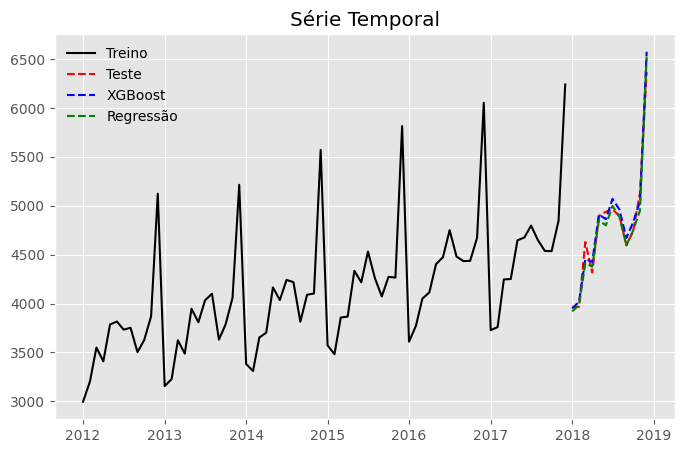

In [72]:
y_train = df.iloc[train_index].copy()
y_test = df.iloc[test_index].copy()

f, ax = plt.subplots(figsize=(8, 5))
plt.plot(y_train, 'k', label='Treino')
plt.plot(y_test, 'r--', label='Teste')
plt.plot(y_test.index, y_xgb_pred[-12:], 'b--', label='XGBoost')

plt.plot(y_test.index, y_reg_pred[-12:], 'g--', label='Regressão')

plt.legend(frameon=False)
plt.title("Série Temporal")
plt.show()

Analisando as previsões sob os espaços das covariáveis:

<b>LEMBRANDO: O ANO NÃO É MAIS UMA COVARIÁVEL PRESENTE NO MODELO. </b>

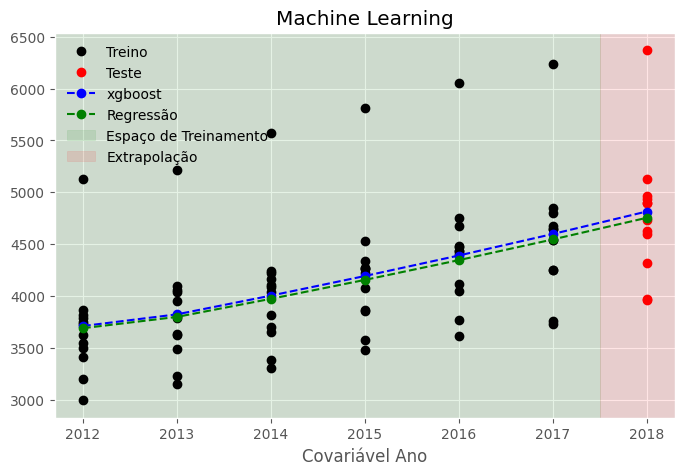

In [73]:
f, ax = plt.subplots(figsize=(8, 5))

plt.plot(y_train.index.year, y_train, 'ko', label='Treino')
plt.plot(y_test.index.year, y_test, 'ro', label='Teste')

xgb_model = pd.Series(y_xgb_pred[1:],
                      index=X_train.index.year.to_list()+X_test.index.year.to_list())
plt.plot(xgb_model.groupby(level=0).mean(), 'b--o', label='xgboost')

reg_model = pd.Series(y_reg_pred[1:],
                      index=X_train.index.year.to_list()+X_test.index.year.to_list())
plt.plot(reg_model.groupby(level=0).mean(), 'g--o', label='Regressão')



ylim, xlim = plt.ylim(), plt.xlim()
plt.fill_betweenx(ylim, xlim[0], 2017.5, alpha=.1, label="Espaço de Treinamento", color="g")
plt.fill_betweenx(ylim, 2017.5, xlim[-1], alpha=.1, label="Extrapolação", color="r")
plt.ylim(ylim), plt.xlim(xlim)


plt.xlabel("Covariável Ano")
plt.legend(frameon=False)
plt.title("Machine Learning")
plt.show()

Nesse caso, apesar de NÃO haver a covariável ano no modelo, é nítido que o modelo aprende um padrão temporal. Um padrão que não foi explicitamente ensinado, afinal, seria impossível fazer isso. Ele aprendeu a relação temporal a partir de uma transformação nos dados. 

Pode-se pensar em Modelos de ML como alunos com zero senso crítico. Nesse caso, não ensinamos sobre uma covariável que ele precisaria extrapolar, mas optams por dar uma matéria "mastigada" pra ele aprender.

Plotando sob a covariável Mês:

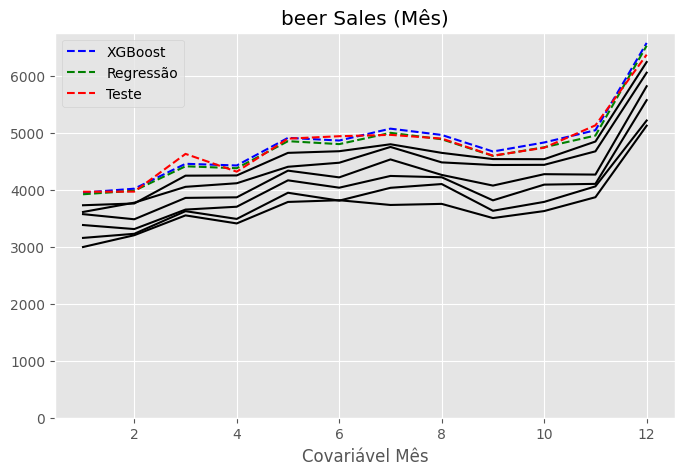

In [74]:
f, ax = plt.subplots(figsize=(8, 5))
for year in y_train.index.year.unique():
    df_temp = y_train.loc[y_train.index.year == year]
    ax.plot(df_temp.index.month, df_temp.beer, color='k')

ax.plot(y_test.index.month, y_xgb_pred[-12:], 'b--', label='XGBoost')
ax.plot(y_test.index.month, y_reg_pred[-12:], 'g--', label='Regressão')
ax.plot(y_test.index.month, y_test, 'r--', label='Teste')

plt.ylim(0)
plt.legend()
plt.xlabel("Covariável Mês")
plt.title("beer Sales (Mês)")
plt.show()

Novamente observa-se um aprendizado muito mais "autêntico" do modelo. Ele não repete a última previsão, mas cria a própria a partir de um padrão entendido nos dados.

# Comentários Finais:

O XGBoost, assim como o LGBM e outros modelos de ML, são bem promissores no contexto de séries temporais. A dor no seu uso resíde na má aplicação deles, que geralmente gira em torno de se esperar uma <i>Panaceia</i> de um modelo matemático. Modelos de ML possuem diversas limitações, extrapolação em covariáveis é uma delas.

Por exemplo, quando usamos o XGBoost com uma covariável que seria extrapolada, tivemos uma performance tosquíssima. A inclusão de novas features sequer melhorou o modelo. Sem um entendimento do que estava acontecendo, esses modelos provavelmente seriam descartados.

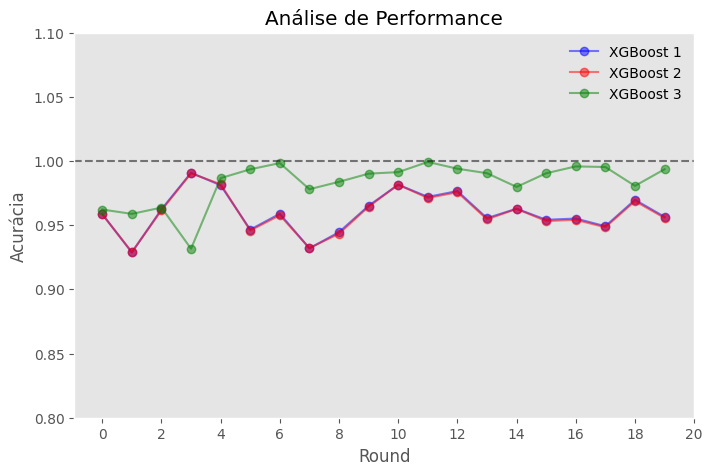

In [75]:
f, ax = plt.subplots(figsize=(8, 5))

ax.plot(acc_xgb_1, 'b-o', alpha=.5, label='XGBoost 1')
ax.plot(acc_xgb_2, 'r-o', alpha=.5, label='XGBoost 2')
ax.plot(acc_xgb_3, 'g-o', alpha=.5, label='XGBoost 3')

plt.ylim(.8, 1.1)
plt.axhline(y=1, color='k', alpha=.5, ls='--')
plt.legend(frameon=False)

plt.xticks(np.arange(0, 22,2))
plt.xlabel("Round")
plt.ylabel("Acurácia")
plt.title("Análise de Performance")
plt.grid(False)
plt.show()

In [76]:
print(f"Modelo 2 vende Modelo 1: {(acc_xgb_2>acc_xgb_1).sum()} ({100*(acc_xgb_2>acc_xgb_1).mean():.0f}%)")

Modelo 2 vende Modelo 1: 3 (15%)


Nesse caso, o Modelo 2, mesmo com mais covariáveis, não foi o suficiente pra performar que o Modelo 1. Isso porque a covariável ano mais atrapalhava do que ajudava o modelo, afinal, ela, por definição seria extrapolada.

Além disso, é interessante lembrar que o modelo é construído baseado em árvores. Muito provavelmente as primeiras camadas de árvore definiam: "se maior ou igual que 2017", sendo 2017 o último dado de treino. Nesse caso, o ano 2018 cai nessa regra e o modelo gera uma previsão similar ao do ano 2017. Em resumo, treinamos um modelo moderníssimo para gerar um naive-forecast.

<i>Lembrando: poderia ser modelada a covariável "t", como tempo desde o primeiro dado de treinamento, ao invés de ano. Nesse caso, o problema de extrapolação ainda existiria. <b> Não coloque covariávels que serão extrapoladas no seu modelo de ML!!!</b> </i>

# Comentários Finais II:

Recapitulando o que foi visto:

- Definiu-se o que são regressões não-paramétricas
<br>
- Foi apresentada uma classe de regressões não-paramétricas, o Gradient Boost Tree Decision
<br>
- Foi explorado os problemas dessa aborgadem na previsão de demanda usando o XGBoost
<br>
- Foi apresentada possíveis soluções para o problema de tendência

Lembrando, foi usado o XGBoost, mas poderia ser usado o LightGBM, o KNN, Splines etc. O ponto central está no entendimento da aplicação desses modelos e suas eventuais limitações.

Outro ponto a se destacar foi a importância da remoção da tendência. Apesar de ser um modelo “moderninho” de machine learning, o que ajudou ele a performar melhor foi um approach mais clássico de séries temporais. 

Outras alternativas de remoção tendência é o uso do conceito de <i>baseline</i>. No caso, um nível basal onde você acredita que a demanda estará e a responsabildiade do modelo será prever o quanto a série oscila em torno disso. Nesse caso, vc precisaria de uma estimativa para esse baseline vinda de outro modelo.

No mais, trata-se de um modelo promissor. É muito usado quando se trata de uma granulalidade alta, seja no tempo (hora, dia etc), seja na previsão (sku, pdv etc), dado que ele entende fácil padrões estruturais.

# Principais Fontes


- Para regressões não-paramétricas, há as notas de aula do professor Lucambio Perez da UFPR: <a href="http://leg.ufpr.br/~lucambio/Nonparam/NparamIV.html" target="_blank" rel="noopener noreferrer">Regressão Não-Paramétrica</a>.
<br>
- Para uma boa introdução ao universo de séries temporais e previsão, o livro <a href="https://otexts.com/fpp3/" target="_blank" rel="noopener noreferrer">Forecasting: Principles & Practice</a>. O livro é todo construído em R, o que pode ser um problema para os pythonistas. Os autores têm excelentes publicações na área de séries temporais, que são devidamente citadas ao longo do livro, então é uma baita livro de cabeceira.
<br>
- Para sofrer um pouquinho com séries temporais e entender a fundo a “lógica” da modelagem de um processo estocástico, o livro <a href="https://www.amazon.com.br/Econometria-S%C3%A9ries-Temporais-Rodrigo-Silveira/dp/852211157X" target="_blank" rel="noopener noreferrer">Econometria de Séries Temporais</a>. Não recomendo como primeira leitura, mas certamente um baita livro para elevar o nível de entendimento no assunto.
<br>
- Para uma introdução no universo do Machine Learning, o livro <a href="https://www.amazon.com.br/M%C3%A3os-obra-aprendizado-scikit-learn-tensorflow/dp/8550803812/ref=sr_1_4?__mk_pt_BR=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=4OWMSIKND5IS&keywords=aprendizado+de+maquina&qid=1703042541&s=books&sprefix=aprendizado+de+maquina%2Cstripbooks%2C262&sr=1-4" target="_blank" rel="noopener noreferrer">Mãos à Obra: Aprendizado de Máquina com Scikit-Learn & TensorFlow</a>. É um livro básico, mas que é legal ter como consulta, como foi o caso na construção do texto.
<br>
- Para mais usos de Aprendizado de Máquina Supervisionado em séries temporais, o livro <a href="https://www.amazon.com.br/Advanced-Forecasting-Python-State-Art-Models/dp/1484271491/ref=sr_1_1?__mk_pt_BR=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=31X3J7B6L1YS&keywords=Advanced+Forecasting+with+Python&qid=1703042592&s=books&sprefix=advanced+forecasting+with+python%2Cstripbooks%2C515&sr=1-1&ufe=app_do%3Aamzn1.fos.4bb5663b-6f7d-4772-84fa-7c7f565ec65b" target="_blank" rel="noopener noreferrer">Advanced Forecasting with Python</a>. Não é tão <i>advanced</i> assim e o autor acaba pecando fortemente na exploração de alguns modelos, mas é o preço que se paga por querer ensinar +10 modelos distintos em menos de 300 pgs.
<br>